# AI for Chemistry: Python and Jupyter Primer

Welcome. This notebook guides you through Python basics with chemistry examples. It is designed for about 40 minutes of live demo time.

### What you will learn
1. How to run cells in Jupyter
2. Python variables and basic math
3. Lists, dictionaries, and loops
4. Writing simple functions
5. Plotting with matplotlib
6. A tiny taste of AI for chemistry using a linear model on calibration data

You can run a cell with **Shift+Enter**. Use **A** to insert a cell above and **B** to insert below when in command mode. Use **M** to change a cell to Markdown and **Y** to change to Code.


## 1. First steps in Python
Python can work as a calculator. We will start with values that show up in chemistry.


In [1]:
# Avogadro's number and simple math
NA = 6.022_140_76e23  # exact by definition
moles = 0.015
particles = moles * NA
print("Particles in", moles, "mol:", particles)

# Unit conversion example: grams to kilograms
grams = 18.0
kilograms = grams / 1000
kilograms

Particles in 0.015 mol: 9.03321114e+21


0.018

## 2. Variables, types, and comments
A variable is a name for a value. The `#` symbol starts a comment that Python ignores. Use comments to explain your work.


In [2]:
# Store atomic masses for a few common elements (g/mol)
atomic_mass = {
    "H": 1.008,
    "C": 12.011,
    "N": 14.007,
    "O": 15.999,
    "Na": 22.990,
    "Cl": 35.45,
}

type(atomic_mass), list(atomic_mass.items())[:3]

(dict, [('H', 1.008), ('C', 12.011), ('N', 14.007)])

## 3. Lists, loops, and a quick chemistry task
We will compute simple molar masses for a few small molecules using a very small dictionary. This is not a full periodic table, but it is enough to get started.


In [3]:
# Simple helper that accepts a formula like H2O or CO2 with only integers for counts
# This keeps things beginner friendly. It handles one or two letter symbols and positive integers.
import re

def molar_mass_simple(formula, masses=atomic_mass):
    tokens = re.findall(r"([A-Z][a-z]?)(\d*)", formula)
    if not tokens:
        raise ValueError("Could not read formula")
    total = 0.0
    for sym, count in tokens:
        if sym not in masses:
            raise KeyError(f"Element {sym} not in mass table")
        n = int(count) if count else 1
        total += masses[sym] * n
    return total

for f in ["H2O", "CO2", "NaCl", "C6H12O6"]:
    print(f, molar_mass_simple(f))

H2O 18.015
CO2 44.009
NaCl 58.44
C6H12O6 180.156


### Practice
Add your own formula to the list above and run the cell. Try CH3OH or C2H5OH.


## 4. Functions made for chemistry
We will write a function that converts a mass of a compound to moles using its molar mass. Then we will compute the number of particles.


In [4]:
def grams_to_moles(grams, formula):
    mm = molar_mass_simple(formula)
    return grams / mm

def particles_from_grams(grams, formula, NA=NA):
    n = grams_to_moles(grams, formula)
    return n * NA

grams = 10.0
formula = "CO2"
n = grams_to_moles(grams, formula)
N = particles_from_grams(grams, formula)
print(f"{grams} g of {formula} is {n:.4f} mol and {N:.3e} particles")

10.0 g of CO2 is 0.2272 mol and 1.368e+23 particles


## 5. Plotting data with matplotlib
We will create a small calibration curve for a dye using the Beer–Lambert idea: `A = ε * l * c`. In practice we collect pairs of concentration and absorbance. We will fit a straight line and use it to estimate an unknown.


slope: 0.41493808857163034
intercept: 0.003071338822485314
R^2: 0.9987029711886003


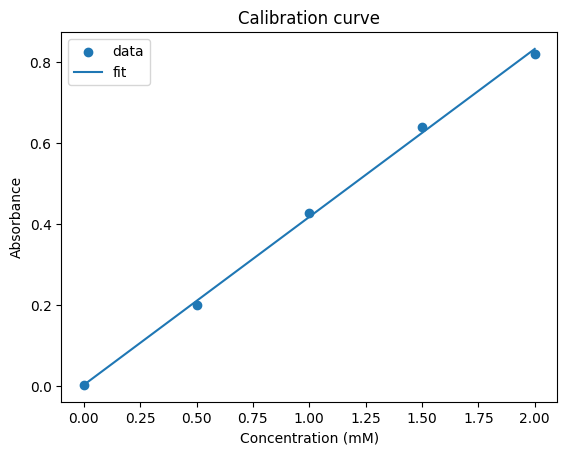

In [5]:
# If matplotlib is not installed in your environment, uncomment the line below
# !pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Make synthetic calibration data (concentration in mM, absorbance unitless)
c = np.array([0.0, 0.5, 1.0, 1.5, 2.0])
true_eps_l = 0.42  # slope
rng = np.random.default_rng(42)
A = true_eps_l * c + rng.normal(0, 0.01, size=c.size)  # small noise

# Fit line with numpy
coeffs = np.polyfit(c, A, 1)
slope, intercept = coeffs[0], coeffs[1]
fit_A = slope * c + intercept

# Compute R^2 by hand for learning
ss_res = np.sum((A - fit_A)**2)
ss_tot = np.sum((A - np.mean(A))**2)
r2 = 1 - ss_res/ss_tot

print("slope:", slope)
print("intercept:", intercept)
print("R^2:", r2)

plt.figure()
plt.scatter(c, A, label="data")
plt.plot(c, fit_A, label="fit")
plt.xlabel("Concentration (mM)")
plt.ylabel("Absorbance")
plt.title("Calibration curve")
plt.legend()
plt.show()

## 6. A tiny AI step: linear regression with scikit-learn
Machine learning can fit a model to data and then make predictions on new samples. We will use a very small dataset to mirror what you saw above. If scikit-learn is not installed, the first cell will install it.


In [6]:
# Uncomment if needed
# !pip install scikit-learn
from sklearn.linear_model import LinearRegression
import numpy as np

# Use the same c and A from above, or recreate them here for safety
c = np.array([0.0, 0.5, 1.0, 1.5, 2.0]).reshape(-1, 1)
A = np.array([0.00, 0.20, 0.41, 0.61, 0.84])  # a small clean set

model = LinearRegression()
model.fit(c, A)
print("slope (epsilon*l):", model.coef_[0])
print("intercept:", model.intercept_)
print("R^2:", model.score(c, A))

# Predict concentration from a new absorbance reading by inverting the line
A_unknown = 0.50
pred_c = (A_unknown - model.intercept_) / model.coef_[0]
print("Predicted concentration for A=0.50:", float(pred_c), "mM")

ModuleNotFoundError: No module named 'sklearn'

## 7. Arrays and simple vectorized chemistry math
NumPy arrays let you apply the same math to many values at once. Here we convert several masses to moles in one step.


In [ ]:
import numpy as np

masses = np.array([9.0, 18.0, 36.0])  # grams of water
mm_H2O = molar_mass_simple("H2O")
moles = masses / mm_H2O
particles_each = moles * NA
masses, moles, particles_each

## 8. Mini project: estimate solution pH for a strong acid by concentration
For a strong monoprotic acid at 25 °C, a rough estimate treats the acid as fully dissociated. Then `[H⁺] ≈ c` and `pH = -log10([H⁺])`. This breaks down at very low concentrations, but it works for a quick check.


In [ ]:
import numpy as np

def estimate_pH_strong_acid(conc_M):
    conc_M = np.asarray(conc_M, dtype=float)
    H = np.clip(conc_M, 1e-14, None)  # guard against log of zero
    return -np.log10(H)

c_values = np.array([1e-1, 1e-2, 1e-3, 1e-4])
pH_values = estimate_pH_strong_acid(c_values)
list(zip(c_values, pH_values))

### Plot the estimate
We will see the near linear trend on a log scale.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

c_grid = np.logspace(-6, 0, 50)
pH_grid = estimate_pH_strong_acid(c_grid)

plt.figure()
plt.semilogx(c_grid, pH_grid)
plt.xlabel("Acid concentration (M)")
plt.ylabel("Estimated pH")
plt.title("Strong acid pH estimate")
plt.show()

## 9. Exercises
Try these on your own. Add new cells as needed.

1. Extend `atomic_mass` with K and Ca, then compute the molar mass of KCl and CaCO3.
2. Modify `molar_mass_simple` to allow parentheses for a case like Ca(OH)2. Hint: count the group, then add to the total.
3. Create your own calibration data for a different range of concentrations and fit a line. Report slope, intercept, and R².
4. Use the fitted line to predict the concentration of an unknown from a measured absorbance.


## 10. Wrap up
You wrote Python code, made functions, plotted data, and built a tiny model that predicts concentration from absorbance. This is the start of using Python and simple AI ideas in chemistry.

Next topics to explore later: reading CSV files with `pandas`, more realistic models for pH, stoichiometry from balanced reactions, and an introduction to molecular descriptors.
